In [1]:
%matplotlib inline
from matplotlib import gridspec, cm
from plot import bootstrap_samples_mean, StyleCycler
from typing import List, Union, Callable
import matplotlib.pyplot as plt
import pandas
import numpy as np
import functools

plt.style.use('seaborn')
plt.style.use('seaborn-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams.update({
    'figure.figsize': (4.8/2, 3/2),
    'text.usetex': True,
    'axes.titlesize': 6,
    'font.size': 5,
    'ytick.labelsize': 3,
    'xtick.labelsize': 3,
    'axes.labelsize': 3,
    'legend.fontsize': 4,
    'lines.markersize': 2,
    'lines.linewidth': 0.5,
    'errorbar.capsize': 2,
    'ytick.major.pad': 2,
    'xtick.major.pad': 2,
    'axes.labelpad': 2
})

## Notes

1. Chose a set of clique size (i.e. 10 / 15 / 20 / 30 or something like that)
2. Aggregate by added (for a missing added) or by added (by a fixed missing)
3. Plot ratio and time, which are the metrics

In [2]:
default_algo = dict(
    findqg_l000 = '$\lambda = 0$',
    findqg_l080 = '$\lambda = 0.8$',
    findqg_L005 = '$\Lambda = 0.05$'
)

In [3]:
def beta(alpha, k):
    a=3.36
    b=-3.71
    c=0.13
    d=-0.93
    e=1.46
    return np.log10(alpha)* a + b * np.log10(alpha) + c * k**2 + d * k + e

def beta2(alpha, k):
    a=2.21
    b=-2.64
    c=0.03
    d=-0.20
    e=0.62
    return np.log10(alpha)* a + b * np.log10(alpha) + c * k**2 + d * k + e

In [4]:
def plot_results(raw: pandas.DataFrame, fix:dict, groupby: str, algorithms: dict=default_algo, xlabel: str=None, fig=None, gs=None, title:str=None,
                 ylabel:bool = False, legend: bool=False, beta:Callable=beta):
    nsamples = 500
    
    cycler = StyleCycler(['o', 's', 'D'], ['--', '-.', ':'], plt.rcParams['axes.prop_cycle'])
    
    if fig is None:
        fig = plt.figure(figsize=(8, 8))
    
    mask = functools.reduce(lambda a, b: a & b, [raw[k] == v for k, v in fix.items()])
    masked = raw[mask]

    agg_mean = dict()
    agg_std = dict()
    for name, grp in masked.groupby(groupby):
        sample_means = pandas.DataFrame([grp.sample(frac=1, replace=True).mean() for _ in range(nsamples)])
        agg_mean[name] = sample_means.mean()
        agg_std[name] = sample_means.std()
    agg_mean = pandas.DataFrame(agg_mean).T
    agg_std = pandas.DataFrame(agg_std).T
    
    agg_timeout = masked.groupby([groupby]).agg({f'{algo}_time': lambda x: x.isnull().sum() for algo in algorithms}).astype(int)
    
    if gs is None:
        grid = gridspec.GridSpec(ncols=1, nrows=5, hspace=0, figure=fig)
    else:
        grid = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=5, hspace=0.15, subplot_spec=gs)
       
    # Ratio
    ax_ratio = fig.add_subplot(grid[0:2, 0])
    for (algo, label), (marker, line, color) in zip(algorithms.items(), cycler):
        ax_ratio.errorbar(agg_mean.index, agg_mean[f'{algo}_jaccard'], yerr=agg_std[f'{algo}_jaccard'],
                          marker=marker, linestyle=line,
                          label=label, c=color)
    if title:
        ax_ratio.set_title(title)
        
    # Time
    ax_time = fig.add_subplot(grid[2:4, 0], sharex=ax_ratio)
    for (algo, label), (marker, line, color) in zip(algorithms.items(), cycler):
        ax_time.errorbar(agg_mean.index, agg_mean[f'{algo}_time'], yerr=agg_std[f'{algo}_time'],
                         marker=marker, linestyle=line,
                         label=label, c=color)
    
    ax_time.set_xticks(agg_mean.index)
    ax_time.set_ylim(0)
    
    # Timeouts
    if len(agg_mean.index) > 2:
        bar_width = (agg_mean.index[-1] - agg_mean.index[-2])/2.
    else:
        bar_width = 0.01
    
    ax_timeout = fig.add_subplot(grid[4, 0], sharex=ax_ratio)
    bottom = np.zeros(len(agg_timeout.index))
    for (algo, label), (marker, line, color) in zip(algorithms.items(), cycler):
        ax_timeout.bar(agg_timeout.index, agg_timeout[f'{algo}_time'], bottom=bottom,
                       width=bar_width, label=label, color=color)
        bottom += agg_timeout[f'{algo}_time']
   
    ax_timeout.set_xlabel(xlabel)
    if not np.any(bottom>0):
        ax_timeout.set_ylim(0, 1)
        ax_timeout.set_yticks([0,])
    ax_timeout.grid(False)
    
    plt.setp(ax_ratio.get_xaxis(), visible=False)
    plt.setp(ax_time.get_xaxis(), visible=False)
    
    # Beta
    ax_beta = ax_timeout.twiny()
    ax_beta.set_xlim(*ax_time.get_xlim())
    ax_beta.set_xticks(agg_mean.index)
    ax_beta.set_xticklabels([f'{beta(a, fix["rank"]):.2f}' for a in agg_mean.index])
    ax_beta.set_xlabel('$\\beta$')
    ax_beta.set_frame_on(True)
    ax_beta.patch.set_visible(False)
    ax_beta.grid(False)
    
    for sp in ax_beta.spines.values():
        sp.set_visible(False)
    ax_beta.spines["bottom"].set_visible(True)
    ax_beta.xaxis.set_ticks_position("bottom")
    ax_beta.xaxis.set_label_position("bottom")
    ax_beta.spines["bottom"].set_position(("axes", -0.6))
       
    if legend:
        ax_timeout.legend(loc='upper center', bbox_to_anchor=(0.5, -1.5), ncol=len(algorithms))
        
    if ylabel:
        ax_ratio.set_ylabel('Jaccard index')
        ax_time.set_ylabel('Time (s)')
        ax_timeout.set_ylabel('Timeouts')
        fig.align_ylabels([ax_ratio, ax_time, ax_timeout])
        
    return fig

In [5]:
la_results = pandas.read_csv('../results/quasi_Lambda_both.csv', index_col=0)

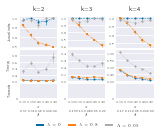

In [6]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(la_results, dict(clique=10, rank=2), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='k=2', ylabel=True)
plot_results(la_results, dict(clique=10, rank=3), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='k=3', legend=True)
plot_results(la_results, dict(clique=10, rank=4), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='k=4')

fig.savefig('/home/aalvarez/Downloads/quasi_corr_10.eps', bbox_inches='tight')

plt.show()

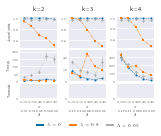

In [7]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(la_results, dict(clique=20, rank=2), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='k=2', ylabel=True)
plot_results(la_results, dict(clique=20, rank=3), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='k=3', legend=True)
plot_results(la_results, dict(clique=20, rank=4), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='k=4')

fig.savefig('/home/aalvarez/Downloads/quasi_corr_20.eps', bbox_inches='tight')

plt.show()

/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/opt/miniconda3/envs/matchbox/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan

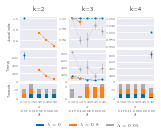

In [8]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(la_results, dict(clique=30, rank=2), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='k=2', ylabel=True)
plot_results(la_results, dict(clique=30, rank=3), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='k=3', legend=True)
plot_results(la_results, dict(clique=30, rank=4), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='k=4')

fig.savefig('/home/aalvarez/Downloads/quasi_corr_30.eps', bbox_inches='tight')

plt.show()

# Different correlation

In [9]:
la2_results = pandas.read_csv('../results/quasi_Lambda_mean.csv', index_col=0)

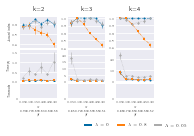

In [10]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.3)

plot_results(la2_results, dict(clique=10, rank=2), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='k=2', beta=beta2, ylabel=True)
plot_results(la2_results, dict(clique=10, rank=3), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='k=3', beta=beta2)
plot_results(la2_results, dict(clique=10, rank=4), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='k=4', beta=beta2, legend=True)

plt.show()

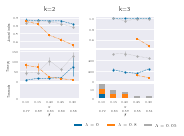

In [11]:
fig = plt.figure()
gs0 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.3)

plot_results(la2_results, dict(clique=20, rank=2), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[0], title='k=2', beta=beta2, ylabel=True)
plot_results(la2_results, dict(clique=20, rank=3), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[1], title='k=3', beta=beta2, legend=True)
#plot_results(la2_results, dict(clique=20, rank=4), groupby='missing', xlabel='$\\alpha$', fig=fig, gs=gs0[2], title='k=4', beta=beta2)

plt.show()